In [74]:
import numpy as np
import transformers
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from utils import general_utils

### Analysis: compare PPLs between fwd and rev trained GPT-2s on neuroscience Train and val set
* Added the previously trained (non-bayes) GPT-2s models for reference.
* Metrics: T-test, cohen's d and Jenson Shannon Divergence (JSD).

In [75]:
# Bayes fwd and rev models
# (train-sampled and validation sets)
fwd_bayes_train_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/all_batches_ppl_train.npy"
rev_bayes_train_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_rev/human_abstracts/all_batches_ppl_train.npy"
fwd_bayes_val_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/all_batches_ppl_validation.npy"
rev_bayes_val_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_rev/human_abstracts/all_batches_ppl_validation.npy"

fwd_bayes_train_ppls = np.load(fwd_bayes_train_path)
rev_bayes_train_ppls = np.load(rev_bayes_train_path)
fwd_bayes_val_ppls = np.load(fwd_bayes_val_path)
rev_bayes_val_ppls = np.load(rev_bayes_val_path)

# Original fwd and bwd models 
# (validation set only)
fwd_path = "model_results/gpt2_scratch_neuro_tokenizer/human_abstracts/all_batches_ppl_validation.npy"
bwd_path = "model_results/gpt2_scratch_neuro_tokenizer_backwards/human_abstracts/all_batches_ppl_validation.npy"

fwd_val_ppls = np.load(fwd_path)
bwd_val_ppls = np.load(bwd_path)

In [3]:
def cohens_d_ind(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    diff_mean = np.mean(x) - np.mean(y)
    pooled_var = ((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof
    return np.abs(diff_mean / np.sqrt(pooled_var))

def cohens_d_rel(x, y):
    diff_mean = np.mean(x) - np.mean(y)
    diff_var = np.var(x - y, ddof=1)
    return np.abs(diff_mean / np.sqrt(diff_var))

### T-test

* Massive difference between paired vs independent t stats
* Paired should be the right thing to do

In [4]:
print("Bayes Val", stats.ttest_rel(fwd_bayes_val_ppls, rev_bayes_val_ppls))
print("Bayes Train", stats.ttest_rel(fwd_bayes_train_ppls, rev_bayes_train_ppls))

Bayes Val TtestResult(statistic=-15.672598361144663, pvalue=1.139724125552024e-54, df=9412)
Bayes Train TtestResult(statistic=-17.7316547078725, pvalue=8.226932024452419e-70, df=19904)


* Recall the previous fwd vs bwd models do not have exactly the same val sample sizes due to retrained tokenizer and padding; hence paired is not allowed.

In [5]:
print("Val (ind)", stats.ttest_ind(fwd_val_ppls, bwd_val_ppls))

Val (ind) TtestResult(statistic=-6.100744173422656, pvalue=1.0764487287906804e-09, df=18767.0)


In [6]:
print("Bayes Val Cohen's d", cohens_d_rel(fwd_bayes_val_ppls, rev_bayes_val_ppls))
print("Bayes Train Cohen's d", cohens_d_rel(fwd_bayes_train_ppls, rev_bayes_train_ppls))
print("Val Cohen's d (ind)", cohens_d_ind(fwd_val_ppls, bwd_val_ppls))

Bayes Val Cohen's d 0.16153884553828604
Bayes Train Cohen's d 0.12568057953519957
Val Cohen's d (ind) 0.08906221471659419


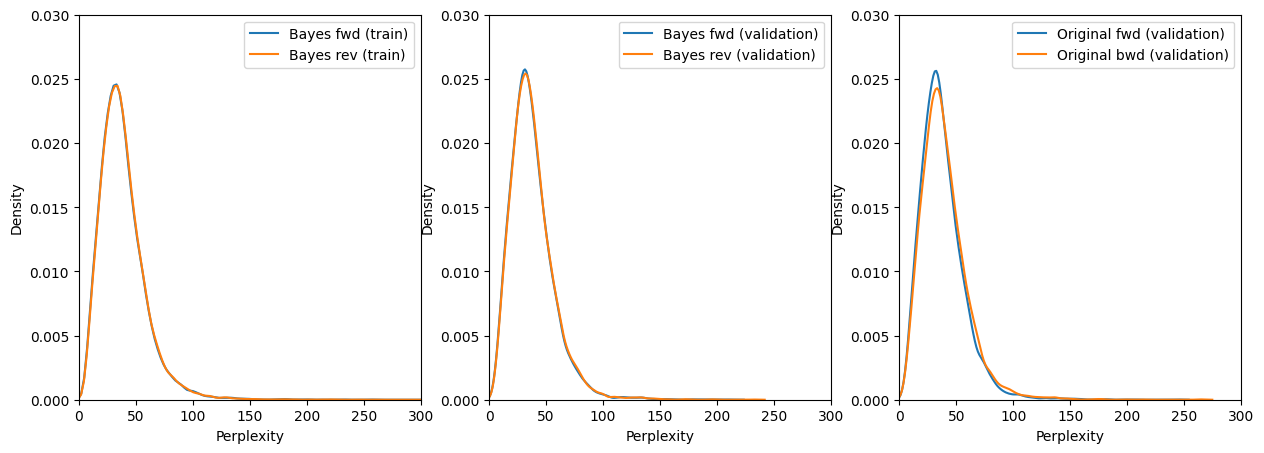

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(fwd_bayes_train_ppls, label="Bayes fwd (train)", ax=axes[0])
sns.kdeplot(rev_bayes_train_ppls, label="Bayes rev (train)", ax=axes[0])
sns.kdeplot(fwd_bayes_val_ppls, label="Bayes fwd (validation)", ax=axes[1])
sns.kdeplot(rev_bayes_val_ppls, label="Bayes rev (validation)", ax=axes[1])
sns.kdeplot(fwd_val_ppls, label="Original fwd (validation)", ax=axes[2])
sns.kdeplot(bwd_val_ppls, label="Original bwd (validation)", ax=axes[2])
axes[0].set_xlabel("Perplexity")
axes[0].legend()
axes[0].set_xlim(0, 300)
axes[0].set_ylim(0, 0.03)
axes[1].set_xlabel("Perplexity")
axes[1].legend()
axes[1].set_xlim(0, 300)
axes[1].set_ylim(0, 0.03)
axes[2].set_xlabel("Perplexity")
axes[2].set_xlim(0, 300)
axes[2].set_ylim(0, 0.03)
axes[2].legend()
plt.show()

### JSD
* Alternative to t-test, free of sample size difference problem.

In [ ]:
print(
    "JSD, bayes, train", distance.jensenshannon(fwd_bayes_train_ppls, rev_bayes_train_ppls)
)

print(
    "JSD, bayes, val", distance.jensenshannon(fwd_bayes_val_ppls, rev_bayes_val_ppls)
)

print(
    "JSD, val", distance.jensenshannon(fwd_val_ppls, bwd_val_ppls)
)

### Analysis: compare PPLs between fwd and rev trained GPT-2s on Brainbench items

### Conclusions:
* Both T-test and cohen's d suggest bayes-trained models show smaller ppl-diff for original and altered items. 
* For bayes-trained models, difference between fwd and rev models is small (effec size < 0.2)
* In terms of JSD, bayes-trained and originally trained show comparable ppl-diff for original and altered items; but overall JSD is small.

In [9]:
def _ppl_original_ppl_altered_and_ppl_diff(PPL_A_and_B, labels, norm=False):
    """
    Args:
        PPL_A_and_B: (N, 2) array of PPL values for A and B
        labels: (N, ) array of labels (0 or 1) where 0 indicates A correct, B incorrect
        norm: normalization method for PPL difference
            False (default): no normalization
            True: normalize by the PPL of the original

    Returns:
        PPL_original: (N, ) array of PPL values of original/correct options
        PPL_altered: (N, ) array of PPL values of altered/incorrect options
        PPL_diff: (N, ) array of PPL difference between altered and original options
    """
    PPL_A = PPL_A_and_B[:, 0]
    PPL_B = PPL_A_and_B[:, 1]
    PPL_original = []
    PPL_altered = []
    PPL_diff = []  # altered - original
    for i, label in enumerate(labels):
        if label == 0:  # A correct, B incorrect
            PPL_original.append(PPL_A[i])
            PPL_altered.append(PPL_B[i])
            diff = PPL_B[i] - PPL_A[i]
            if norm is True:
                diff /= PPL_A[i]
            PPL_diff.append(diff)
        else:
            PPL_original.append(PPL_B[i])
            PPL_altered.append(PPL_A[i])
            diff = PPL_A[i] - PPL_B[i]
            if norm is True:
                diff /= PPL_B[i]
            PPL_diff.append(diff)
    return np.array(PPL_original), np.array(PPL_altered), np.array(PPL_diff)

def _per_item_correctness(PPL_A_and_B, labels):
    """
    Args:
        PPL_A_and_B: (N, 2) array of PPL values for A and B
        labels: (N, ) array of labels (0 or 1) where 0 indicates A correct, B incorrect

    Returns:
        correctness: (N, ) array of correctness values (1 if correct, 0 if incorrect)
    """
    correctness = []
    PPL_A = PPL_A_and_B[:, 0]
    PPL_B = PPL_A_and_B[:, 1]
    for i, label in enumerate(labels):
        if label == 0:  # A correct, B incorrect
            correctness.append(1 if PPL_A[i] < PPL_B[i] else 0)
        else:
            correctness.append(1 if PPL_B[i] < PPL_A[i] else 0)
    return np.array(correctness)

In [10]:
general_utils.scorer_acc

<function utils.general_utils.scorer_acc(PPL_A_and_B, labels)>

In [11]:
# Bayes fwd and rev models
fwd_bayes_brainbench_ppls_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/PPL_A_and_B.npy"
fwd_bayes_brainbench_labels_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/labels.npy"
rev_bayes_brainbench_ppls_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_rev/human_abstracts/PPL_A_and_B.npy"
rev_bayes_brainbench_labels_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_rev/human_abstracts/labels.npy"

fwd_brainbench_ppls_path = "model_results/gpt2_scratch_neuro_tokenizer/human_abstracts/PPL_A_and_B.npy"
fwd_brainbench_labels_path = "model_results/gpt2_scratch_neuro_tokenizer/human_abstracts/labels.npy"
bwd_brainbench_ppls_path = "model_results/gpt2_scratch_neuro_tokenizer_backwards/human_abstracts/PPL_A_and_B.npy"
bwd_brainbench_labels_path = "model_results/gpt2_scratch_neuro_tokenizer_backwards/human_abstracts/labels.npy"

fwd_bayes_brainbench_ppls = np.load(fwd_bayes_brainbench_ppls_path)
fwd_bayes_brainbench_labels = np.load(fwd_bayes_brainbench_labels_path)
rev_bayes_brainbench_ppls = np.load(rev_bayes_brainbench_ppls_path)
rev_bayes_brainbench_labels = np.load(rev_bayes_brainbench_labels_path)

# Original fwd and bwd models
fwd_brainbench_ppls = np.load(fwd_brainbench_ppls_path)
fwd_brainbench_labels = np.load(fwd_brainbench_labels_path)
bwd_brainbench_ppls = np.load(bwd_brainbench_ppls_path)
bwd_brainbench_labels = np.load(bwd_brainbench_labels_path)

fwd_bayes_brainbench_ppls_original, fwd_bayes_brainbench_ppls_altered, fwd_bayes_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)
rev_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_altered, rev_bayes_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)

fwd_brainbench_ppls_original, fwd_brainbench_ppls_altered, fwd_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(fwd_brainbench_ppls, fwd_brainbench_labels)
bwd_brainbench_ppls_original, bwd_brainbench_ppls_altered, bwd_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(bwd_brainbench_ppls, bwd_brainbench_labels)

print(fwd_bayes_brainbench_ppls_original.shape, fwd_bayes_brainbench_ppls_diff.shape)
print(rev_bayes_brainbench_ppls_original.shape, rev_bayes_brainbench_ppls_diff.shape)


(200,) (200,)
(200,) (200,)


In [12]:
# Get acc
fwd_bayes_brainbench_acc = general_utils.scorer_acc(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)
rev_bayes_brainbench_acc = general_utils.scorer_acc(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)
fwd_brainbench_acc = general_utils.scorer_acc(fwd_brainbench_ppls, fwd_brainbench_labels)
bwd_brainbench_acc = general_utils.scorer_acc(bwd_brainbench_ppls, bwd_brainbench_labels)
print("Bayes fwd brainbench acc", fwd_bayes_brainbench_acc)
print("Bayes rev brainbench acc", rev_bayes_brainbench_acc)
print("Fwd brainbench acc", fwd_brainbench_acc)
print("Bwd brainbench acc", bwd_brainbench_acc)

# Sanity check acc
print('\nSanity check acc')
print("Bayes fwd brainbench acc", np.mean(_per_item_correctness(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)))
print("Bayes rev brainbench acc", np.mean(_per_item_correctness(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)))
print("Fwd brainbench acc", np.mean(_per_item_correctness(fwd_brainbench_ppls, fwd_brainbench_labels)))
print("Bwd brainbench acc", np.mean(_per_item_correctness(bwd_brainbench_ppls, bwd_brainbench_labels)))

Bayes fwd brainbench acc 0.605
Bayes rev brainbench acc 0.64
Fwd brainbench acc 0.625
Bwd brainbench acc 0.64

Sanity check acc
Bayes fwd brainbench acc 0.605
Bayes rev brainbench acc 0.64
Fwd brainbench acc 0.625
Bwd brainbench acc 0.64


In [13]:
# T-test (ppl original)
print(
    "Bayes Brainbench",
    stats.ttest_rel(fwd_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_original),
)

print(
    "Brainbench",
    stats.ttest_rel(fwd_brainbench_ppls_original, bwd_brainbench_ppls_original),
)

Bayes Brainbench TtestResult(statistic=2.117760377137123, pvalue=0.03543670106655037, df=199)
Brainbench TtestResult(statistic=-9.36798335477271, pvalue=1.6490264300274633e-17, df=199)


In [14]:
# T-test (ppl altered)
print(
    "Bayes Brainbench",
    stats.ttest_rel(fwd_bayes_brainbench_ppls_altered, rev_bayes_brainbench_ppls_altered),
)

print(
    "Brainbench",
    stats.ttest_rel(fwd_brainbench_ppls_altered, bwd_brainbench_ppls_altered),
)

Bayes Brainbench TtestResult(statistic=1.9212736465551556, pvalue=0.056126111455141986, df=199)
Brainbench TtestResult(statistic=-9.124224120120754, pvalue=8.121712652679595e-17, df=199)


In [15]:
# T-test (ppl diff)
print(
    "Bayes Brainbench",
    stats.ttest_rel(fwd_bayes_brainbench_ppls_diff, rev_bayes_brainbench_ppls_diff),
)
print(
    "Brainbench",
    stats.ttest_rel(fwd_brainbench_ppls_diff, bwd_brainbench_ppls_diff),
)

Bayes Brainbench TtestResult(statistic=-0.8480519914921127, pvalue=0.397427891551025, df=199)
Brainbench TtestResult(statistic=0.3110397595151271, pvalue=0.7560959664791471, df=199)


In [16]:
# Cohens' d (ppl original)
print(
    "Bayes Brainbench Cohen's d",
    cohens_d_rel(fwd_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_original),
)

print(
    "Original Brainbench Cohen's d",
    cohens_d_rel(fwd_brainbench_ppls_original, bwd_brainbench_ppls_original),
)

Bayes Brainbench Cohen's d 0.14974827236018215
Original Brainbench Cohen's d 0.6624164556202489


In [17]:
# Cohens' d (ppl altered)
print(
    "Bayes Brainbench Cohen's d",
    cohens_d_rel(fwd_bayes_brainbench_ppls_altered, rev_bayes_brainbench_ppls_altered),
)

print(
    "Original Brainbench Cohen's d",
    cohens_d_rel(fwd_brainbench_ppls_altered, bwd_brainbench_ppls_altered),
)

Bayes Brainbench Cohen's d 0.1358545623994156
Original Brainbench Cohen's d 0.6451800748403246


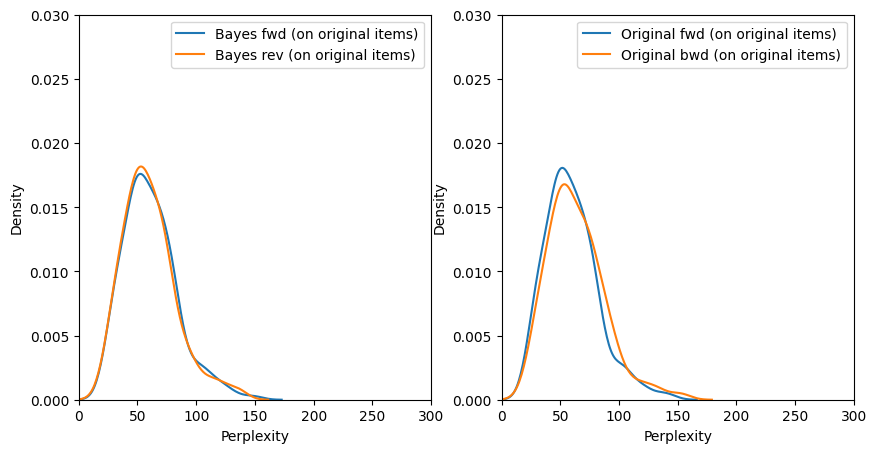

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(fwd_bayes_brainbench_ppls_original, label="Bayes fwd (on original items)", ax=axes[0])
sns.kdeplot(rev_bayes_brainbench_ppls_original, label="Bayes rev (on original items)", ax=axes[0])
sns.kdeplot(fwd_brainbench_ppls_original, label="Original fwd (on original items)", ax=axes[1])
sns.kdeplot(bwd_brainbench_ppls_original, label="Original bwd (on original items)", ax=axes[1])
axes[0].set_xlabel("Perplexity")
axes[0].legend()
axes[0].set_xlim(0, 300)
axes[0].set_ylim(0, 0.03)
axes[1].set_xlabel("Perplexity")
axes[1].set_xlim(0, 300)
axes[1].set_ylim(0, 0.03)
axes[1].legend()
plt.show()

In [19]:
# JSD (ppl original)
print(
    "JSD, Bayes, Brainbench",
    distance.jensenshannon(fwd_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_original),
)

print(
    "JSD, Brainbench",
    distance.jensenshannon(fwd_brainbench_ppls_original, bwd_brainbench_ppls_original),
)

JSD, Bayes, Brainbench 0.026120063057237883
JSD, Brainbench 0.029840276818802282


### Aanalysis: BrainBench performance vs item fwd & rev ppl diff
* This is to examine whether magnitude of discrepency in PPL of the same item processed by fwd and rev trained models (i.e., `fwd_rev_bayes_brainbench_<original|altered>_ppl_diff`) correlates with that item's BrainBench accuracy (both in terms of `ppl(altered-original)` as continuous accuracy and binary outcome)
    - Plot 1: For a given model (fwd or rev), we compare if a smaller fwd-rev ppl-diff indicates higher altered-original ppl-diff (continuous) by fitting a linear regression.
    - Plot 2: For a given model (fwd or rev), we compare if a smaller fwd-rev ppl-diff indicates correctness (binary) by fitting a linear regression and logistic regression.
    - Plot 3: Same analysis as 2 but plot by grouping `fwd-rev ppl-diff` based on correctness and compare distributional difference (statistical analysis wise is identical to Plot 2 linear regression).

### Results:
1. Without normalizing `fwd_rev_bayes_brainbench_<original|altered>_ppl_diff`, we observe no strong correlation between `fwd_rev_bayes_brainbench_<original|altered>_ppl_diff` and `ppl(altered-original)`
2. Without normalzing `fwd_rev_bayes_brainbench_<original|altered>_ppl_diff`, we observe marginal significant correlation between correctness and `fwd_rev_bayes_brainbench_<original|altered>_ppl_diff`.
3. With normalizing, the 2. significance gone.
4. Normalizing by mean produces similar result as normalizing by max/min only difference is the distribution shifts -> suggesting significant correlation is due to absolute magnitude not ratio.

In [91]:
fwd_rev_bayes_brainbench_original_ppl_diff_abs \
    = np.abs(fwd_bayes_brainbench_ppls_original - rev_bayes_brainbench_ppls_original)
fwd_rev_bayes_brainbench_altered_ppl_diff_abs \
    = np.abs(fwd_bayes_brainbench_ppls_altered - rev_bayes_brainbench_ppls_altered)

# fwd_rev_bayes_brainbench_original_ppl_diff_abs \
#     = np.maximum(fwd_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_original) \
#     / np.minimum(fwd_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_original)
# fwd_rev_bayes_brainbench_altered_ppl_diff_abs \
#     = np.maximum(fwd_bayes_brainbench_ppls_altered, rev_bayes_brainbench_ppls_altered) \
#     / np.minimum(fwd_bayes_brainbench_ppls_altered, rev_bayes_brainbench_ppls_altered)

# fwd_rev_bayes_brainbench_original_ppl_diff_abs \
#     = np.abs(fwd_bayes_brainbench_ppls_original + rev_bayes_brainbench_ppls_original)
# fwd_rev_bayes_brainbench_altered_ppl_diff_abs \
#     = np.abs(fwd_bayes_brainbench_ppls_altered + rev_bayes_brainbench_ppls_altered)

# Set normalization to raw differences.
norm_fwd_rev_ppl_diff = False
norm_altered_original_ppl_diff = False

### Side-request for 3:
* Hypothesis: the significance in 2. was due to magnitude of the diff; and the magnitude of the diff could be correlated with items ppls hence the correlation is simply reflecting that items with high ppls, model end up getting incorrect.
* -> As observed below, the diff correlates with both original and altered ppls!
* -> And, original and altered ppls correlate with correctness for GPT2! Hence, diff correlates with correctness when unnormalized.

* We check correlation between `fwd_bayes_brainbench_ppls_<original|altered>` and `fwd_rev_bayes_brainbench_original_ppl_diff_abs`

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     40.75
Date:                Sun, 06 Apr 2025   Prob (F-statistic):           1.20e-09
Time:                        09:34:33   Log-Likelihood:                -890.99
No. Observations:                 200   AIC:                             1786.
Df Residuals:                     198   BIC:                             1793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.0505      2.151     23.733      0.0

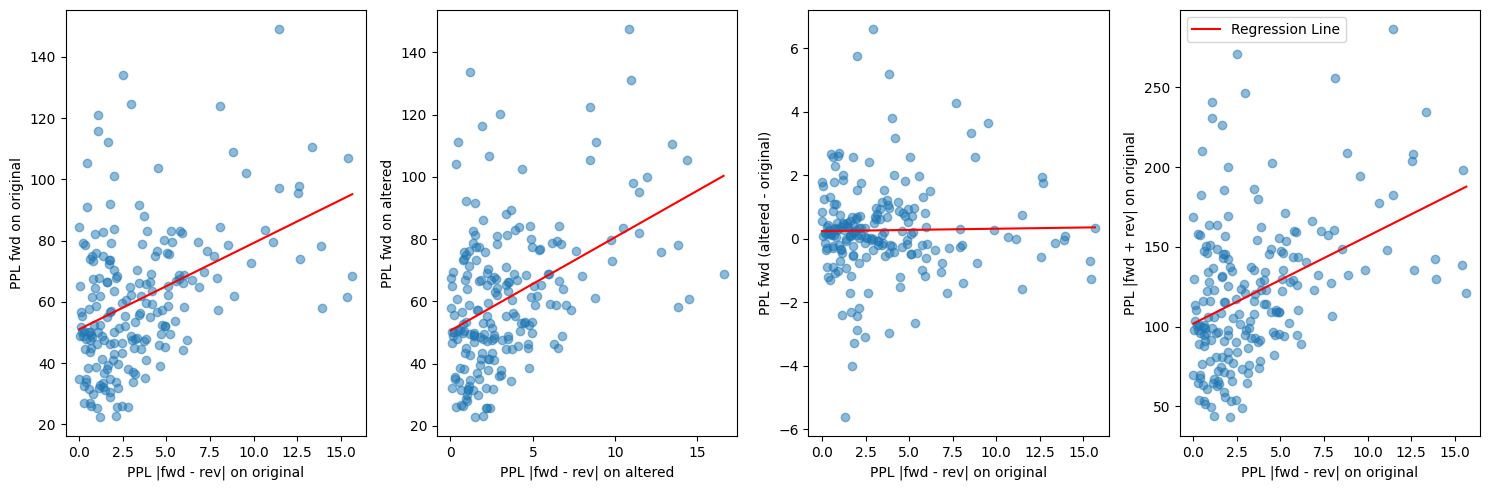

In [92]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs,
    fwd_bayes_brainbench_ppls_original,
    alpha=0.5,
)
axes[0].set_xlabel("PPL |fwd - rev| on original")
axes[0].set_ylabel("PPL fwd on original")

# Fit a linear regression model
X = sm.add_constant(fwd_rev_bayes_brainbench_original_ppl_diff_abs)
y = fwd_bayes_brainbench_ppls_original
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Plot the regression line
x_vals = np.linspace(fwd_rev_bayes_brainbench_original_ppl_diff_abs.min(), fwd_rev_bayes_brainbench_original_ppl_diff_abs.max(), 100)
y_vals = results.predict(sm.add_constant(x_vals))
axes[0].plot(x_vals, y_vals, color='red', label='Regression Line')

axes[1].scatter(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs,
    fwd_bayes_brainbench_ppls_altered,
    alpha=0.5,
)
axes[1].set_xlabel("PPL |fwd - rev| on altered")
axes[1].set_ylabel("PPL fwd on altered")

# Fit a linear regression model
X = sm.add_constant(fwd_rev_bayes_brainbench_altered_ppl_diff_abs)
y = fwd_bayes_brainbench_ppls_altered
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
# Plot the regression line
x_vals = np.linspace(fwd_rev_bayes_brainbench_altered_ppl_diff_abs.min(), fwd_rev_bayes_brainbench_altered_ppl_diff_abs.max(), 100)
y_vals = results.predict(sm.add_constant(x_vals))
axes[1].plot(x_vals, y_vals, color='red', label='Regression Line')

axes[2].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs,
    fwd_bayes_brainbench_ppls_diff,
    alpha=0.5,
)
axes[2].set_xlabel("PPL |fwd - rev| on original")
axes[2].set_ylabel("PPL fwd (altered - original)")

# Fit a linear regression model
X = sm.add_constant(fwd_rev_bayes_brainbench_original_ppl_diff_abs)
y = fwd_bayes_brainbench_ppls_diff
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Plot the regression line
x_vals = np.linspace(fwd_rev_bayes_brainbench_original_ppl_diff_abs.min(), fwd_rev_bayes_brainbench_original_ppl_diff_abs.max(), 100)
y_vals = results.predict(sm.add_constant(x_vals))
axes[2].plot(x_vals, y_vals, color='red', label='Regression Line')

axes[3].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs,
    np.abs(fwd_bayes_brainbench_ppls_original + rev_bayes_brainbench_ppls_original),
    alpha=0.5,
)
axes[3].set_xlabel("PPL |fwd - rev| on original")
axes[3].set_ylabel("PPL |fwd + rev| on original")

# Fit a linear regression model
X = sm.add_constant(fwd_rev_bayes_brainbench_original_ppl_diff_abs)
y = np.abs(fwd_bayes_brainbench_ppls_original + rev_bayes_brainbench_ppls_original)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
# Plot the regression line
x_vals = np.linspace(fwd_rev_bayes_brainbench_original_ppl_diff_abs.min(), fwd_rev_bayes_brainbench_original_ppl_diff_abs.max(), 100)
y_vals = results.predict(sm.add_constant(x_vals))
axes[3].plot(x_vals, y_vals, color='red', label='Regression Line')
axes[3].legend()
plt.tight_layout()
plt.show()


* How does ppl originals and altered correlate with correctness already?
* -> Quite strongly! Which suggests high ppl items gpt2 will likely get wrong;
* -> And interestingly, in high ppl range, both original and altered are high but model couldn't get right still.

Fwd Bayes acc = 0.605
Rev Bayes acc = 0.64

Bayes Fwd model (x-axis: Brainbench original)
--------------------
Slope: -0.0047871592896153855
Intercept: 0.8970964436131769
R-squared: 0.05013209214268511
P-value: 0.0014367394163716483
--------------------
Optimization terminated successfully.
         Current function value: 0.645699
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Apr 2025   Pseudo R-squ.:                 0.03761
Time:                        09:34:33   Log-Likelihood:                -129.14
converged:                       True   LL-Null:                       -134.19
Covariance Type:            nonrobust   LLR p-value:                  0.001488
            

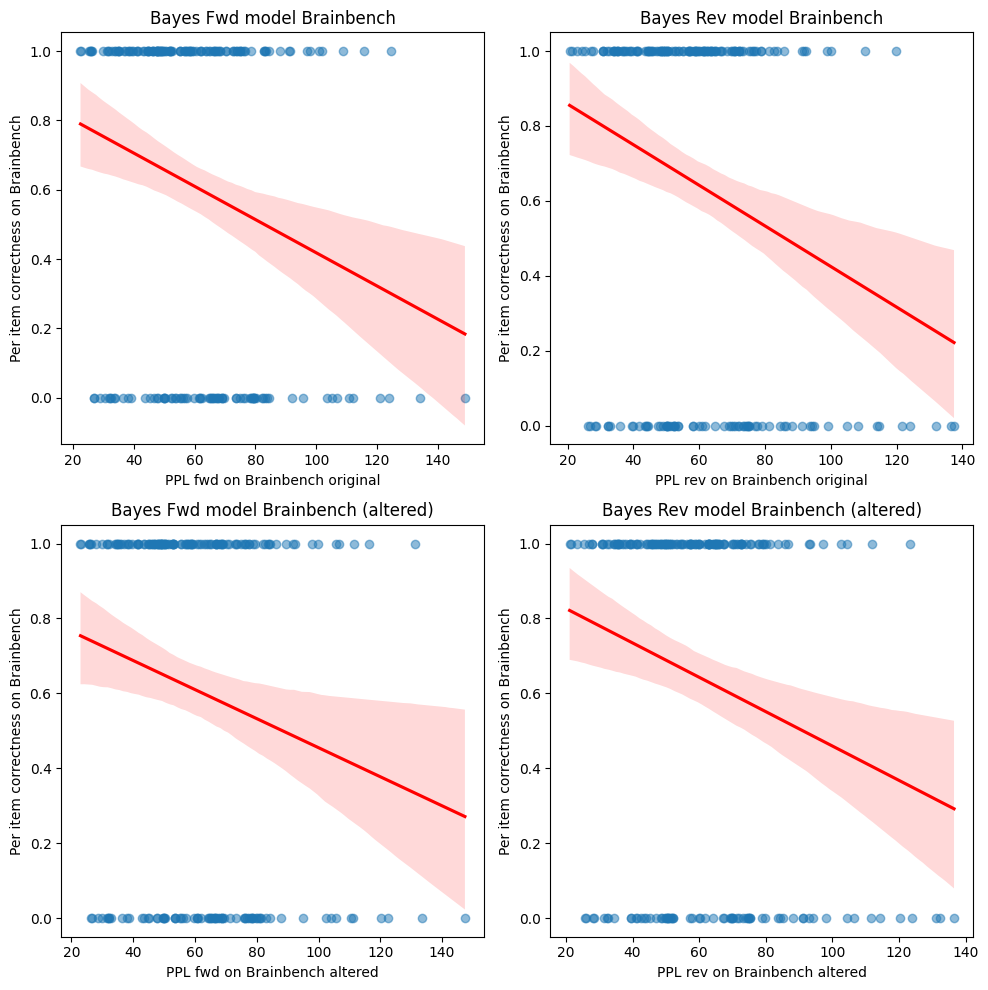

In [93]:
fwd_bayes_brainbench_per_item_correctness = _per_item_correctness(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)
rev_bayes_brainbench_per_item_correctness = _per_item_correctness(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)
print(f"Fwd Bayes acc = {np.mean(fwd_bayes_brainbench_per_item_correctness)}")
print(f"Rev Bayes acc = {np.mean(rev_bayes_brainbench_per_item_correctness)}")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# subplot 0: Bayes Fwd model Brainbench (x-axis: Brainbench original)
axes[0].scatter(
    fwd_bayes_brainbench_ppls_original,
    fwd_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)

axes[0].set_xlabel("PPL fwd on Brainbench original")
axes[0].set_ylabel("Per item correctness on Brainbench")
axes[0].set_title("Bayes Fwd model Brainbench")

# Fit line
sns.regplot(
    x=fwd_bayes_brainbench_ppls_original,
    y=fwd_bayes_brainbench_per_item_correctness,
    ax=axes[0],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_bayes_brainbench_ppls_original, fwd_bayes_brainbench_per_item_correctness
)
print("\nBayes Fwd model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("-" * 20)
x = fwd_bayes_brainbench_ppls_original
y = fwd_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())

# subplot 1: Bayes Rev model Brainbench (x-axis: Brainbench original)
axes[1].scatter(
    rev_bayes_brainbench_ppls_original,
    rev_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[1].set_xlabel("PPL rev on Brainbench original")
axes[1].set_ylabel("Per item correctness on Brainbench")
axes[1].set_title("Bayes Rev model Brainbench")
# Fit line
sns.regplot(
    x=rev_bayes_brainbench_ppls_original,
    y=rev_bayes_brainbench_per_item_correctness,
    ax=axes[1],
    scatter=False,
    color="red",
)
# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    rev_bayes_brainbench_ppls_original, rev_bayes_brainbench_per_item_correctness
)
print("\nBayes Rev model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("-" * 20)
x = rev_bayes_brainbench_ppls_original
y = rev_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())

# subplot 2: Bayes Fwd model Brainbench (x-axis: Brainbench altered)
axes[2].scatter(
    fwd_bayes_brainbench_ppls_altered,
    fwd_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[2].set_xlabel("PPL fwd on Brainbench altered")
axes[2].set_ylabel("Per item correctness on Brainbench")
axes[2].set_title("Bayes Fwd model Brainbench (altered)")
# Fit line
sns.regplot(
    x=fwd_bayes_brainbench_ppls_altered,
    y=fwd_bayes_brainbench_per_item_correctness,
    ax=axes[2],
    scatter=False,
    color="red",
)
# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_bayes_brainbench_ppls_altered, fwd_bayes_brainbench_per_item_correctness
)
print("\nBayes Fwd model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("-" * 20)
x = fwd_bayes_brainbench_ppls_altered
y = fwd_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())

# subplot 3: Bayes Rev model Brainbench (x-axis: Brainbench altered)
axes[3].scatter(
    rev_bayes_brainbench_ppls_altered,
    rev_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[3].set_xlabel("PPL rev on Brainbench altered")
axes[3].set_ylabel("Per item correctness on Brainbench")
axes[3].set_title("Bayes Rev model Brainbench (altered)")
# Fit line
sns.regplot(
    x=rev_bayes_brainbench_ppls_altered,
    y=rev_bayes_brainbench_per_item_correctness,
    ax=axes[3],
    scatter=False,
    color="red",
)
# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    rev_bayes_brainbench_ppls_altered, rev_bayes_brainbench_per_item_correctness
)
print("\nBayes Rev model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("-" * 20)
x = rev_bayes_brainbench_ppls_altered
y = rev_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())
plt.tight_layout()

* How did stronger LLMs correlate between ppl original|altered and correctness? 
* -> Not much an indicator for correctness (looked galactica and mistral.)

Acc = 0.83

Mistral model (x-axis: Brainbench original)
--------------------
Slope: -0.008761758417437277
Intercept: 0.8941641466483558
R-squared: 0.0020915488287418676
P-value: 0.5201908031988918
--------------------
Optimization terminated successfully.
         Current function value: 0.454857
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Apr 2025   Pseudo R-squ.:                0.002258
Time:                        09:34:34   Log-Likelihood:                -90.971
converged:                       True   LL-Null:                       -91.177
Covariance Type:            nonrobust   LLR p-value:                    0.5211
                 coef    std err          z     

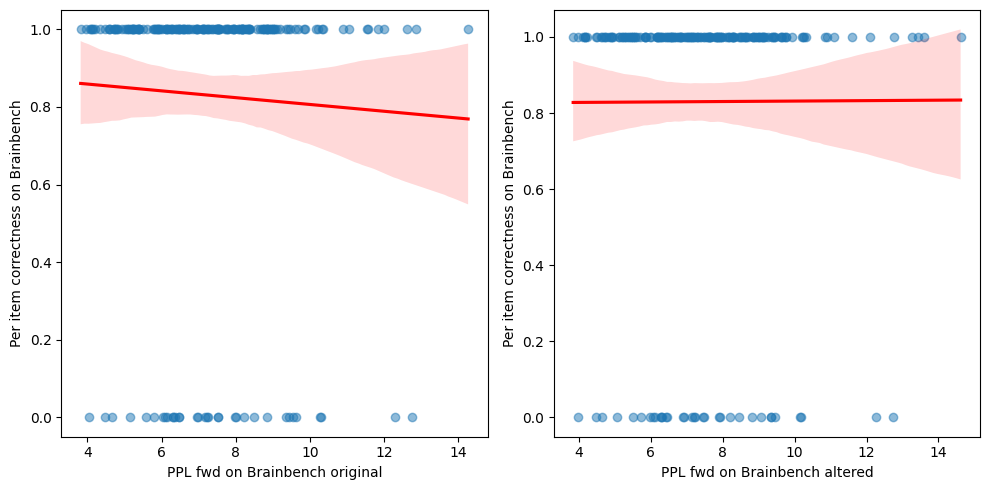

In [94]:
model_name = "facebook/galactica-6.7b"
model_name = "mistralai/Mistral-7B-v0.1"

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

mistral_brainbench_ppls_path = f"model_results/{model_name.replace('/', '--')}/human_abstracts/PPL_A_and_B.npy"
mistral_brainbench_labels_path = f"model_results/{model_name.replace('/', '--')}/human_abstracts/labels.npy"

mistral_brainbench_ppls = np.load(mistral_brainbench_ppls_path)
mistral_brainbench_labels = np.load(mistral_brainbench_labels_path)

mistral_brainbench_ppls_original, mistral_brainbench_ppls_altered, mistral_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(mistral_brainbench_ppls, mistral_brainbench_labels)


mistral_brainbench_per_item_correctness = _per_item_correctness(mistral_brainbench_ppls, mistral_brainbench_labels)
print(f"Acc = {np.mean(mistral_brainbench_per_item_correctness)}")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# subplot 0: mistral Brainbench (x-axis: Brainbench original)
axes[0].scatter(
    mistral_brainbench_ppls_original,
    mistral_brainbench_per_item_correctness,
    alpha=0.5,
)

axes[0].set_xlabel("PPL fwd on Brainbench original")
axes[0].set_ylabel("Per item correctness on Brainbench")

# Fit line
sns.regplot(
    x=mistral_brainbench_ppls_original,
    y=mistral_brainbench_per_item_correctness,
    ax=axes[0],
    scatter=False,
    color="red",
)
# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    mistral_brainbench_ppls_original, mistral_brainbench_per_item_correctness
)
print("\nMistral model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("-" * 20)
x = mistral_brainbench_ppls_original
y = mistral_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())
plt.tight_layout()

# subplot 1: mistral Brainbench (x-axis: Brainbench altered)
axes[1].scatter(
    mistral_brainbench_ppls_altered,
    mistral_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[1].set_xlabel("PPL fwd on Brainbench altered")
axes[1].set_ylabel("Per item correctness on Brainbench")
# Fit line
sns.regplot(
    x=mistral_brainbench_ppls_altered,
    y=mistral_brainbench_per_item_correctness,
    ax=axes[1],
    scatter=False,
    color="red",
)
# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    mistral_brainbench_ppls_altered, mistral_brainbench_per_item_correctness
)
print("\nMistral model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("-" * 20)
x = mistral_brainbench_ppls_altered
y = mistral_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())
plt.tight_layout()



* It looks like for gpt2 small ppl|fwd-rev| correlates ppl of brainbench items. How about correlation between train/valid items? Is there something more general, i.e., how well a model learns a text sequence in terms of ppl is related in how different fwd and rev models learn this sequence?

Subplot 0 (Fwd Train):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     5674.
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:34:35   Log-Likelihood:                -85702.
No. Observations:               19905   AIC:                         1.714e+05
Df Residuals:                   19903   BIC:                         1.714e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9166      0.

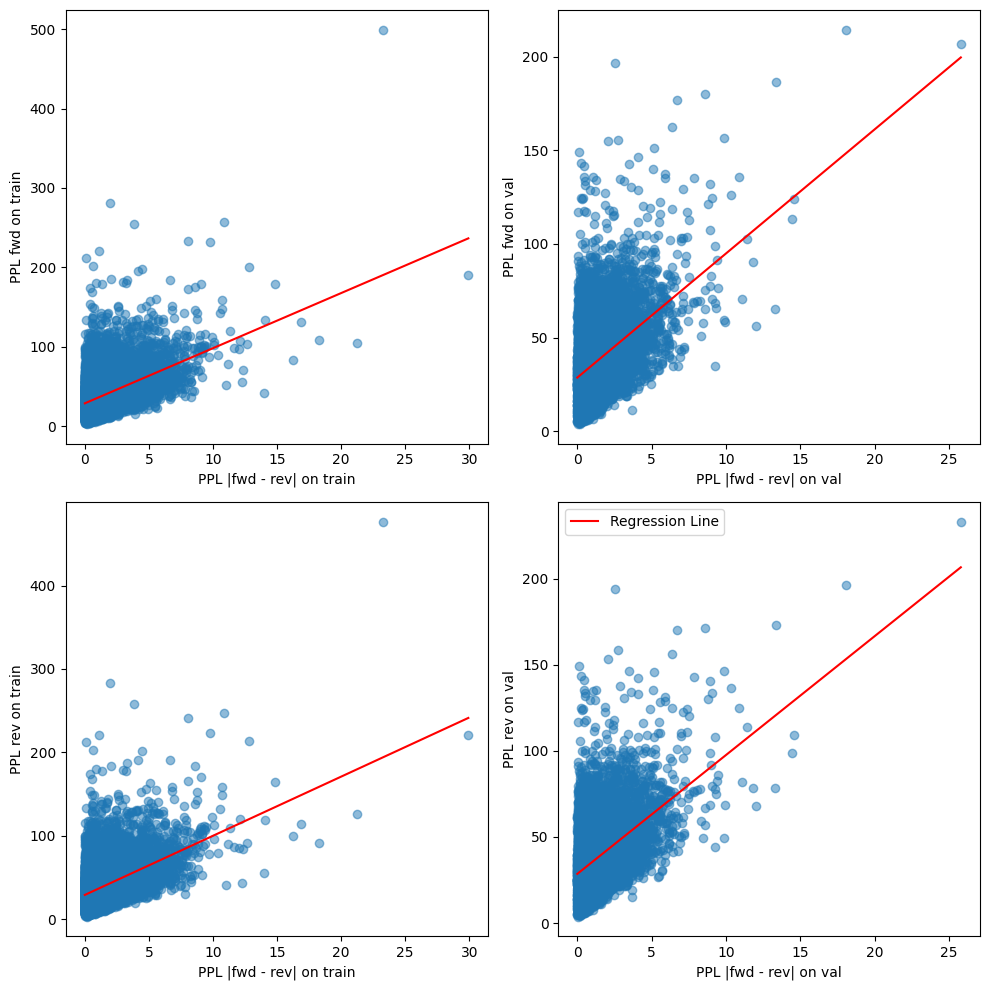

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load data (assuming these are your file paths)
fwd_bayes_train_ppls = np.load(fwd_bayes_train_path)
rev_bayes_train_ppls = np.load(rev_bayes_train_path)
fwd_bayes_val_ppls = np.load(fwd_bayes_val_path)
rev_bayes_val_ppls = np.load(rev_bayes_val_path)

fwd_rev_bayes_train_ppls_diff_abs = np.abs(fwd_bayes_train_ppls - rev_bayes_train_ppls)
fwd_rev_bayes_val_ppls_diff_abs = np.abs(fwd_bayes_val_ppls - rev_bayes_val_ppls)

# Function to remove outliers using IQR method
def remove_outliers(x, y, threshold=1.5):
    q25_x, q75_x = np.percentile(x, [25, 75])
    iqr_x = q75_x - q25_x
    lower_bound_x = q25_x - threshold * iqr_x
    upper_bound_x = q75_x + threshold * iqr_x
    
    q25_y, q75_y = np.percentile(y, [25, 75])
    iqr_y = q75_y - q25_y
    lower_bound_y = q25_y - threshold * iqr_y
    upper_bound_y = q75_y + threshold * iqr_y
    
    mask = (x >= lower_bound_x) & (x <= upper_bound_x) & (y >= lower_bound_y) & (y <= upper_bound_y)
    return x[mask], y[mask]

# Add an option to control outlier removal
remove_outliers_flag = False  # Set to False to keep outliers

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# Subplot 0: Bayes Fwd model Train 
x0, y0 = fwd_rev_bayes_train_ppls_diff_abs, fwd_bayes_train_ppls
if remove_outliers_flag:
    x0, y0 = remove_outliers(x0, y0)
axes[0].scatter(x0, y0, alpha=0.5)
axes[0].set_xlabel("PPL |fwd - rev| on train")
axes[0].set_ylabel("PPL fwd on train")
X = sm.add_constant(x0)
model = sm.OLS(y0, X)
results = model.fit()
print("Subplot 0 (Fwd Train):")
print(results.summary())
x_vals = np.linspace(x0.min(), x0.max(), 100)
y_vals = results.predict(sm.add_constant(x_vals))
axes[0].plot(x_vals, y_vals, color='red', label='Regression Line')

# Subplot 1: Bayes Fwd model Val
x1, y1 = fwd_rev_bayes_val_ppls_diff_abs, fwd_bayes_val_ppls
if remove_outliers_flag:
    x1, y1 = remove_outliers(x1, y1)
axes[1].scatter(x1, y1, alpha=0.5)
axes[1].set_xlabel("PPL |fwd - rev| on val")
axes[1].set_ylabel("PPL fwd on val")
X = sm.add_constant(x1)
model = sm.OLS(y1, X)
results = model.fit()
print("Subplot 1 (Fwd Val):")
print(results.summary())
x_vals = np.linspace(x1.min(), x1.max(), 100)
y_vals = results.predict(sm.add_constant(x_vals))
axes[1].plot(x_vals, y_vals, color='red', label='Regression Line')

# Subplot 2: Bayes Rev model Train
x2, y2 = fwd_rev_bayes_train_ppls_diff_abs, rev_bayes_train_ppls
if remove_outliers_flag:
    x2, y2 = remove_outliers(x2, y2)
axes[2].scatter(x2, y2, alpha=0.5)
axes[2].set_xlabel("PPL |fwd - rev| on train")
axes[2].set_ylabel("PPL rev on train")
X = sm.add_constant(x2)
model = sm.OLS(y2, X)
results = model.fit()
print("Subplot 2 (Rev Train):")
print(results.summary())
x_vals = np.linspace(x2.min(), x2.max(), 100)
y_vals = results.predict(sm.add_constant(x_vals))
axes[2].plot(x_vals, y_vals, color='red', label='Regression Line')

# Subplot 3: Bayes Rev model Val
x3, y3 = fwd_rev_bayes_val_ppls_diff_abs, rev_bayes_val_ppls
if remove_outliers_flag:
    x3, y3 = remove_outliers(x3, y3)
axes[3].scatter(x3, y3, alpha=0.5)
axes[3].set_xlabel("PPL |fwd - rev| on val")
axes[3].set_ylabel("PPL rev on val")
X = sm.add_constant(x3)
model = sm.OLS(y3, X)
results = model.fit()
print("Subplot 3 (Rev Val):")
print(results.summary())
x_vals = np.linspace(x3.min(), x3.max(), 100)
y_vals = results.predict(sm.add_constant(x_vals))
axes[3].plot(x_vals, y_vals, color='red', label='Regression Line')
axes[3].legend()

plt.tight_layout()
plt.show()

### Main results.

* Intuitively see how normalization changes `fwd_rev_bayes_brainbench_original_ppl_diff_abs`

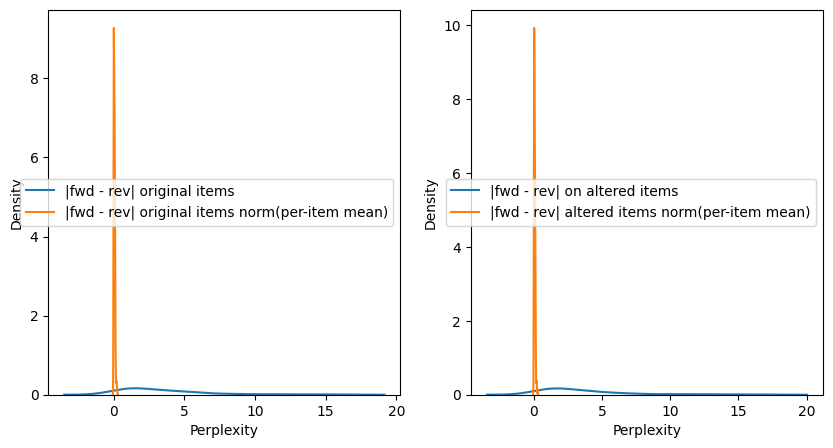

In [96]:
# 1. Normalize per-item by mean
fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm1 \
    = np.abs(fwd_bayes_brainbench_ppls_original - rev_bayes_brainbench_ppls_original) \
    / np.mean([fwd_bayes_brainbench_ppls_original, rev_bayes_brainbench_ppls_original], axis=0)
fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm1 \
    = np.abs(fwd_bayes_brainbench_ppls_altered - rev_bayes_brainbench_ppls_altered) \
    / np.mean([fwd_bayes_brainbench_ppls_altered, rev_bayes_brainbench_ppls_altered], axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(fwd_rev_bayes_brainbench_original_ppl_diff_abs, label="|fwd - rev| original items", ax=axes[0])
sns.kdeplot(fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm1, label="|fwd - rev| original items norm(per-item mean)", ax=axes[0])
sns.kdeplot(fwd_rev_bayes_brainbench_altered_ppl_diff_abs, label="|fwd - rev| on altered items", ax=axes[1])
sns.kdeplot(fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm1, label="|fwd - rev| altered items norm(per-item mean)", ax=axes[1])

axes[0].set_xlabel("Perplexity")
axes[0].legend()
axes[1].set_xlabel("Perplexity")
axes[1].legend()

* Intuitively see how normalization changes `fwd_bayes_brainbench_ppls_diff` and `rev_bayes_brainbench_ppls_diff`

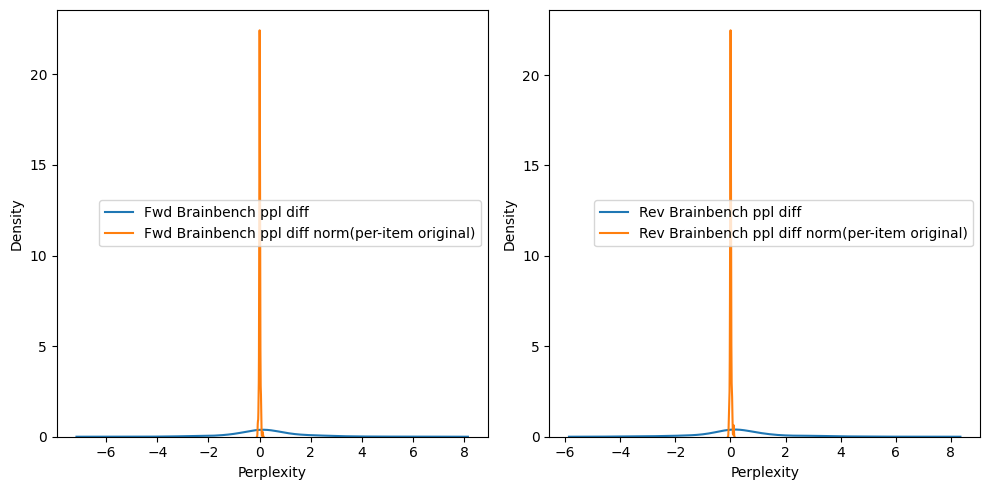

In [97]:
# 1. Normalize per-item by orignal
_, _, fwd_bayes_brainbench_ppls_diff_norm1 = _ppl_original_ppl_altered_and_ppl_diff(
    fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels, norm=True)
_, _, rev_bayes_brainbench_ppls_diff_norm1 = _ppl_original_ppl_altered_and_ppl_diff(
    rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels, norm=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(fwd_bayes_brainbench_ppls_diff, label="Fwd Brainbench ppl diff", ax=axes[0])
sns.kdeplot(fwd_bayes_brainbench_ppls_diff_norm1, label="Fwd Brainbench ppl diff norm(per-item original)", ax=axes[0])
sns.kdeplot(rev_bayes_brainbench_ppls_diff, label="Rev Brainbench ppl diff", ax=axes[1])
sns.kdeplot(rev_bayes_brainbench_ppls_diff_norm1, label="Rev Brainbench ppl diff norm(per-item original)", ax=axes[1])

axes[0].set_xlabel("Perplexity")
axes[0].legend()
axes[1].set_xlabel("Perplexity")
axes[1].legend()
plt.tight_layout()

In [98]:
if norm_fwd_rev_ppl_diff is True:
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm = fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm1
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm = fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm1
else:
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm = fwd_rev_bayes_brainbench_original_ppl_diff_abs
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm = fwd_rev_bayes_brainbench_altered_ppl_diff_abs

if norm_altered_original_ppl_diff is True:
    fwd_bayes_brainbench_ppls_diff_norm = fwd_bayes_brainbench_ppls_diff_norm1
    rev_bayes_brainbench_ppls_diff_norm = rev_bayes_brainbench_ppls_diff_norm1
else:
    fwd_bayes_brainbench_ppls_diff_norm = fwd_bayes_brainbench_ppls_diff
    rev_bayes_brainbench_ppls_diff_norm = rev_bayes_brainbench_ppls_diff


Bayes Fwd model (x-axis: Brainbench original)
--------------------
Slope: 0.007548002910054507
Intercept: 0.24189749608178196
R-squared: 0.0002887987751137303
P-value: 0.8112269954072153

Bayes Rev model (x-axis: Brainbench original)
--------------------
Slope: 0.003984455769822818
Intercept: 0.3237716726929212
R-squared: 7.849775870367381e-05
P-value: 0.9009075862659366

Bayes Fwd model (x-axis: Brainbench altered)
--------------------
Slope: 0.06059702226912768
Intercept: 0.05367608203377741
R-squared: 0.018127357285725815
P-value: 0.057328735928530716

Bayes Rev model (x-axis: Brainbench altered)
--------------------
Slope: 0.004073298666781223
Intercept: 0.323427597500508
R-squared: 7.989368355136223e-05
P-value: 0.9000349385026619


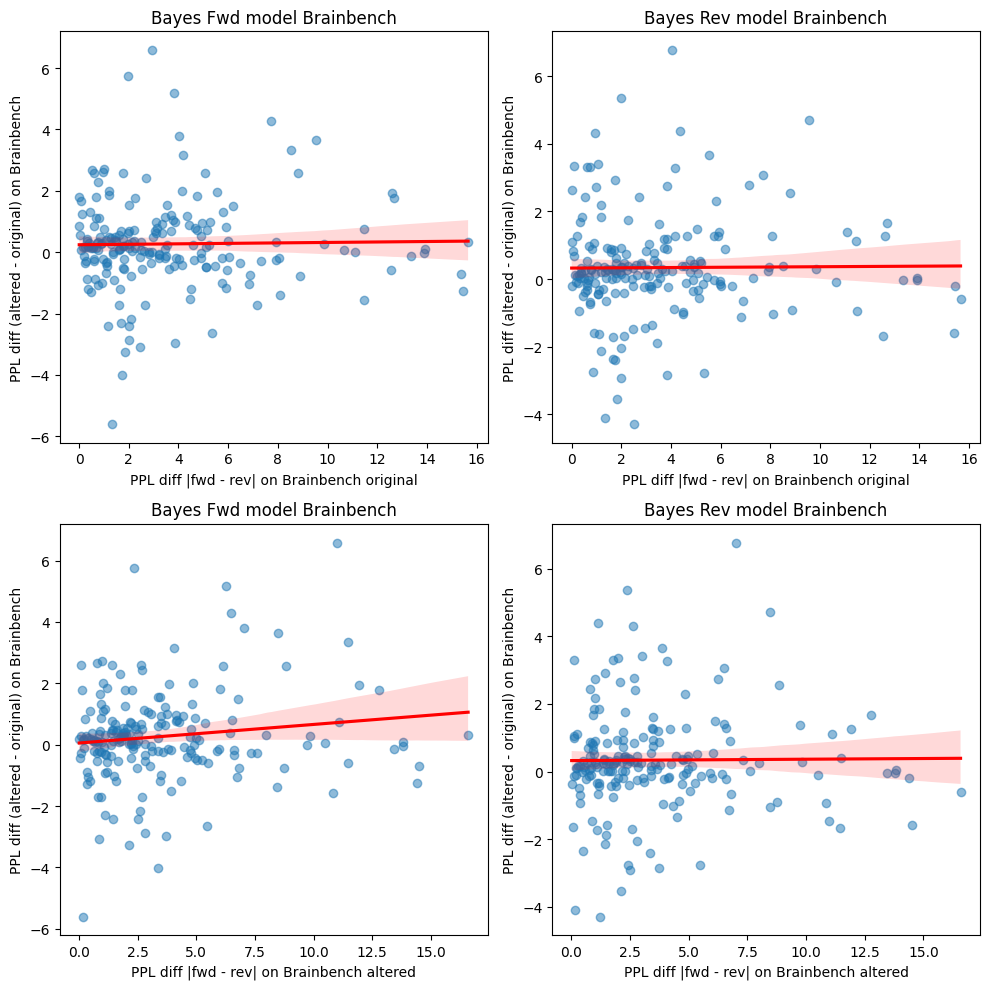

In [99]:
### Plot 1:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# subplot 0: Bayes Fwd model Brainbench (x-axis: Brainbench original)
axes[0].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm,
    fwd_bayes_brainbench_ppls_diff_norm,
    alpha=0.5,
)
axes[0].set_xlabel("PPL diff |fwd - rev| on Brainbench original")
axes[0].set_ylabel("PPL diff (altered - original) on Brainbench")
axes[0].set_title("Bayes Fwd model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm,
    y=fwd_bayes_brainbench_ppls_diff_norm,
    ax=axes[0],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm, fwd_bayes_brainbench_ppls_diff_norm
)
print("\nBayes Fwd model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 1: Bayes Rev model Brainbench (x-axis: Brainbench original)
axes[1].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm,
    rev_bayes_brainbench_ppls_diff_norm,
    alpha=0.5,
)
axes[1].set_xlabel("PPL diff |fwd - rev| on Brainbench original")
axes[1].set_ylabel("PPL diff (altered - original) on Brainbench")
axes[1].set_title("Bayes Rev model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm,
    y=rev_bayes_brainbench_ppls_diff_norm,
    ax=axes[1],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm, rev_bayes_brainbench_ppls_diff_norm
)
print("\nBayes Rev model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)


# subplot 2: Bayes Fwd model Brainbench (x-axis: Brainbench altered)
axes[2].scatter(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm,
    fwd_bayes_brainbench_ppls_diff_norm,
    alpha=0.5,
)
axes[2].set_xlabel("PPL diff |fwd - rev| on Brainbench altered")
axes[2].set_ylabel("PPL diff (altered - original) on Brainbench")
axes[2].set_title("Bayes Fwd model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm,
    y=fwd_bayes_brainbench_ppls_diff_norm,
    ax=axes[2],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm, fwd_bayes_brainbench_ppls_diff_norm
)
print("\nBayes Fwd model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 3: Bayes Rev model Brainbench (x-axis: Brainbench altered)
axes[3].scatter(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm,
    rev_bayes_brainbench_ppls_diff_norm,
    alpha=0.5,
)
axes[3].set_xlabel("PPL diff |fwd - rev| on Brainbench altered")
axes[3].set_ylabel("PPL diff (altered - original) on Brainbench")
axes[3].set_title("Bayes Rev model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm,
    y=rev_bayes_brainbench_ppls_diff_norm,
    ax=axes[3],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm, rev_bayes_brainbench_ppls_diff_norm
)
print("\nBayes Rev model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

plt.tight_layout()
plt.show()

Fwd Bayes acc = 0.605
Rev Bayes acc = 0.64

Bayes Fwd model (x-axis: Brainbench original)
--------------------
Slope: -0.021673248461179427
Intercept: 0.6817182562518147
R-squared: 0.022126143362417194
P-value: 0.035540480896045466

Bayes Rev model (x-axis: Brainbench original)
--------------------
Slope: -0.01714450968733375
Intercept: 0.7006875748165079
R-squared: 0.014360773637464222
P-value: 0.0909864669587052

Bayes Fwd model (x-axis: Brainbench altered)
--------------------
Slope: -0.01199961926459067
Intercept: 0.6475630356695263
R-squared: 0.006605311969382775
P-value: 0.25259705147378825

Bayes Rev model (x-axis: Brainbench altered)
--------------------
Slope: -0.02039678530366144
Intercept: 0.7123480538241084
R-squared: 0.019794833161018814
P-value: 0.0469070085826461


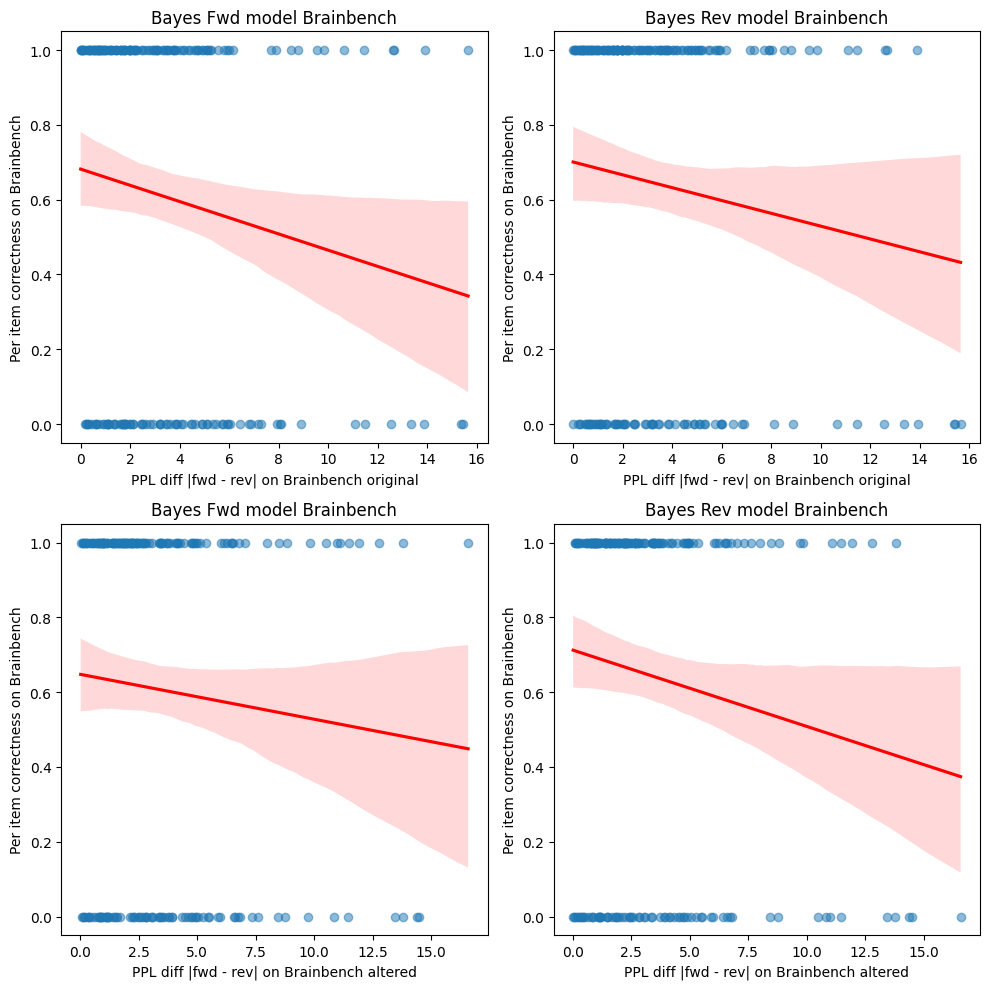

In [100]:
### Plot 2:
fwd_bayes_brainbench_per_item_correctness = _per_item_correctness(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)
rev_bayes_brainbench_per_item_correctness = _per_item_correctness(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)
print(f"Fwd Bayes acc = {np.mean(fwd_bayes_brainbench_per_item_correctness)}")
print(f"Rev Bayes acc = {np.mean(rev_bayes_brainbench_per_item_correctness)}")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# subplot 0: Bayes Fwd model Brainbench (x-axis: Brainbench original)
axes[0].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm,
    fwd_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)

axes[0].set_xlabel("PPL diff |fwd - rev| on Brainbench original")
axes[0].set_ylabel("Per item correctness on Brainbench")
axes[0].set_title("Bayes Fwd model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm,
    y=fwd_bayes_brainbench_per_item_correctness,
    ax=axes[0],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm, fwd_bayes_brainbench_per_item_correctness
)
print("\nBayes Fwd model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 1: Bayes Rev model Brainbench (x-axis: Brainbench original)
axes[1].scatter(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm,
    rev_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[1].set_xlabel("PPL diff |fwd - rev| on Brainbench original")
axes[1].set_ylabel("Per item correctness on Brainbench")
axes[1].set_title("Bayes Rev model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm,
    y=rev_bayes_brainbench_per_item_correctness,
    ax=axes[1],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm, rev_bayes_brainbench_per_item_correctness
)
print("\nBayes Rev model (x-axis: Brainbench original)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 2: Bayes Fwd model Brainbench (x-axis: Brainbench altered)
axes[2].scatter(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm,
    fwd_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[2].set_xlabel("PPL diff |fwd - rev| on Brainbench altered")
axes[2].set_ylabel("Per item correctness on Brainbench")
axes[2].set_title("Bayes Fwd model Brainbench")

# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm,
    y=fwd_bayes_brainbench_per_item_correctness,
    ax=axes[2],
    scatter=False,
    color="red",
)
# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm, fwd_bayes_brainbench_per_item_correctness
)
print("\nBayes Fwd model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

# subplot 3: Bayes Rev model Brainbench (x-axis: Brainbench altered)
axes[3].scatter(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm,
    rev_bayes_brainbench_per_item_correctness,
    alpha=0.5,
)
axes[3].set_xlabel("PPL diff |fwd - rev| on Brainbench altered")
axes[3].set_ylabel("Per item correctness on Brainbench")
axes[3].set_title("Bayes Rev model Brainbench")
# Fit line
sns.regplot(
    x=fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm,
    y=rev_bayes_brainbench_per_item_correctness,
    ax=axes[3],
    scatter=False,
    color="red",
)
# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm, rev_bayes_brainbench_per_item_correctness
)
print("\nBayes Rev model (x-axis: Brainbench altered)")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

plt.tight_layout()
plt.show()

In [101]:
print("\nBayes Fwd model (x-axis: Brainbench original)")
print("-" * 20)
x = fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm
y = fwd_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())

print("\nBayes Rev model (x-axis: Brainbench original)")
print("-" * 20)
x = fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm
y = rev_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())

print("\nBayes Fwd model (x-axis: Brainbench altered)")
print("-" * 20)
x = fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm
y = fwd_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())

print("\nBayes Rev model (x-axis: Brainbench altered)")
print("-" * 20)
x = fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm
y = rev_bayes_brainbench_per_item_correctness
x = sm.add_constant(x)
model = sm.Logit(y, x)
result = model.fit()
print(result.summary())


Bayes Fwd model (x-axis: Brainbench original)
--------------------
Optimization terminated successfully.
         Current function value: 0.660023
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Apr 2025   Pseudo R-squ.:                 0.01626
Time:                        09:34:37   Log-Likelihood:                -132.00
converged:                       True   LL-Null:                       -134.19
Covariance Type:            nonrobust   LLR p-value:                   0.03671
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7499      0.215      3.

In [102]:
fwd_bayes_brainbench_per_item_correctness = _per_item_correctness(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)
rev_bayes_brainbench_per_item_correctness = _per_item_correctness(rev_bayes_brainbench_ppls, rev_bayes_brainbench_labels)
print(f"Fwd Bayes acc = {np.mean(fwd_bayes_brainbench_per_item_correctness)}")
print(f"Rev Bayes acc = {np.mean(rev_bayes_brainbench_per_item_correctness)}")

Fwd Bayes acc = 0.605
Rev Bayes acc = 0.64


Bayes Brainbench fwd model (original items) TtestResult(statistic=-2.116625570294052, pvalue=0.035540480896045466, df=198.0)
Bayes Brainbench rev model (original items) TtestResult(statistic=-1.6984881603407795, pvalue=0.0909864669587052, df=198.0)
Bayes Brainbench fwd model (altered items) TtestResult(statistic=-1.1474092469859227, pvalue=0.2525970514737886, df=198.0)
Bayes Brainbench rev model (altered items) TtestResult(statistic=-1.999631751993019, pvalue=0.0469070085826461, df=198.0)


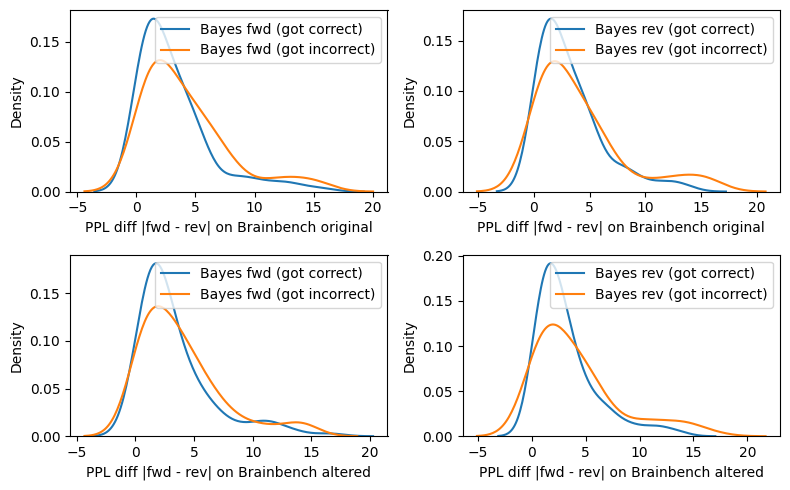

In [103]:
### Plot 3:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes = axes.flatten()

# subplot 0: Bayes Fwd model Brainbench
# two distributions are: 
# i) ppl-diff between fwd and rev models for original brainbench items the fwd model got correct
# ii) ppl-diff between fwd and rev models for original brainbench items the fwd model got incorrect
fwd_rev_bayes_brainbench_original_ppl_diff_abs_correct = fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm[
    fwd_bayes_brainbench_per_item_correctness == 1
]
fwd_rev_bayes_brainbench_original_ppl_diff_abs_incorrect = fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm[
    fwd_bayes_brainbench_per_item_correctness == 0
]

sns.kdeplot(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_correct,
    label="Bayes fwd (got correct)",
    ax=axes[0],
)
sns.kdeplot(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_incorrect,
    label="Bayes fwd (got incorrect)",
    ax=axes[0],
)
axes[0].set_xlabel("PPL diff |fwd - rev| on Brainbench original")
axes[0].legend()

# T-test
print(
    "Bayes Brainbench fwd model (original items)",
    stats.ttest_ind(
        fwd_rev_bayes_brainbench_original_ppl_diff_abs_correct,
        fwd_rev_bayes_brainbench_original_ppl_diff_abs_incorrect,
    ),
)

# subplot 1: Bayes Rev model Brainbench
# two distributions are:
# i) ppl-diff between fwd and rev models for original brainbench items the rev model got correct
# ii) ppl-diff between fwd and rev models for original brainbench items the rev model got incorrect
fwd_rev_bayes_brainbench_original_ppl_diff_abs_correct = fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm[
    rev_bayes_brainbench_per_item_correctness == 1
]
fwd_rev_bayes_brainbench_original_ppl_diff_abs_incorrect = fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm[
    rev_bayes_brainbench_per_item_correctness == 0
]

sns.kdeplot(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_correct,
    label="Bayes rev (got correct)",
    ax=axes[1],
)
sns.kdeplot(
    fwd_rev_bayes_brainbench_original_ppl_diff_abs_incorrect,
    label="Bayes rev (got incorrect)",
    ax=axes[1],
)
axes[1].set_xlabel("PPL diff |fwd - rev| on Brainbench original")
axes[1].legend()

# T-test
print(
    "Bayes Brainbench rev model (original items)",
    stats.ttest_ind(
        fwd_rev_bayes_brainbench_original_ppl_diff_abs_correct,
        fwd_rev_bayes_brainbench_original_ppl_diff_abs_incorrect,
    ),
)

# subplot 2: Bayes Fwd model Brainbench
# two distributions are:
# i) ppl-diff between fwd and rev models for altered brainbench items the fwd model got correct
# ii) ppl-diff between fwd and rev models for altered brainbench items the fwd model got incorrect
fwd_rev_bayes_brainbench_altered_ppl_diff_abs_correct = fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm[
    fwd_bayes_brainbench_per_item_correctness == 1
]
fwd_rev_bayes_brainbench_altered_ppl_diff_abs_incorrect = fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm[
    fwd_bayes_brainbench_per_item_correctness == 0
]
sns.kdeplot(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_correct,
    label="Bayes fwd (got correct)",
    ax=axes[2],
)
sns.kdeplot(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_incorrect,
    label="Bayes fwd (got incorrect)",
    ax=axes[2],
)
axes[2].set_xlabel("PPL diff |fwd - rev| on Brainbench altered")
axes[2].legend()

# T-test
print(
    "Bayes Brainbench fwd model (altered items)",
    stats.ttest_ind(
        fwd_rev_bayes_brainbench_altered_ppl_diff_abs_correct,
        fwd_rev_bayes_brainbench_altered_ppl_diff_abs_incorrect,
    ),
)

# subplot 3: Bayes Rev model Brainbench
# two distributions are:
# i) ppl-diff between fwd and rev models for altered brainbench items the rev model got correct
# ii) ppl-diff between fwd and rev models for altered brainbench items the rev model got incorrect
fwd_rev_bayes_brainbench_altered_ppl_diff_abs_correct = fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm[
    rev_bayes_brainbench_per_item_correctness == 1
]
fwd_rev_bayes_brainbench_altered_ppl_diff_abs_incorrect = fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm[
    rev_bayes_brainbench_per_item_correctness == 0
]
sns.kdeplot(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_correct,
    label="Bayes rev (got correct)",
    ax=axes[3],
)
sns.kdeplot(
    fwd_rev_bayes_brainbench_altered_ppl_diff_abs_incorrect,
    label="Bayes rev (got incorrect)",
    ax=axes[3],
)
axes[3].set_xlabel("PPL diff |fwd - rev| on Brainbench altered")
axes[3].legend()

# T-test
print(
    "Bayes Brainbench rev model (altered items)",
    stats.ttest_ind(
        fwd_rev_bayes_brainbench_altered_ppl_diff_abs_correct,
        fwd_rev_bayes_brainbench_altered_ppl_diff_abs_incorrect,
    ),
)

plt.tight_layout()

### Analysis: fwd-rev-ppl-diff of original vs. altered as indicator for correctness
* Unlike the previous analysis which looked at correlation between either original or altered's fwd-rev-ppl-diff as indicator, here we took a second diff, which is the signed diff of the fwd-rev-ppl-diff of original vs. altered abstracts.
* This diff of diff is signed to indicate prediction; i.e., higher diff -> predicting the item is an altered item.
* `signed_diff_of_diff` is the same for fwd and rev bayes models.

In [104]:
# fwd_rev_bayes_brainbench_original_ppl_diff_abs
# fwd_rev_bayes_brainbench_altered_ppl_diff_abs
# fwd_bayes_brainbench_ppls_diff
# rev_bayes_brainbench_ppls_diff
# fwd_bayes_brainbench_per_item_correctness
# rev_bayes_brainbench_per_item_correctness
signed_diff_of_diff = fwd_rev_bayes_brainbench_altered_ppl_diff_abs_norm - fwd_rev_bayes_brainbench_original_ppl_diff_abs_norm
print(len(signed_diff_of_diff))

200



Bayes Fwd model
--------------------
Slope: 0.5270975814747056
Intercept: 0.26478637129520305
R-squared: 0.13751153283315704
P-value: 6.467985269754166e-08

Bayes Rev model
--------------------
Slope: -0.00018020396558084207
Intercept: 0.33787702810653697
R-squared: 1.5677390321212943e-08
P-value: 0.9985960198407355


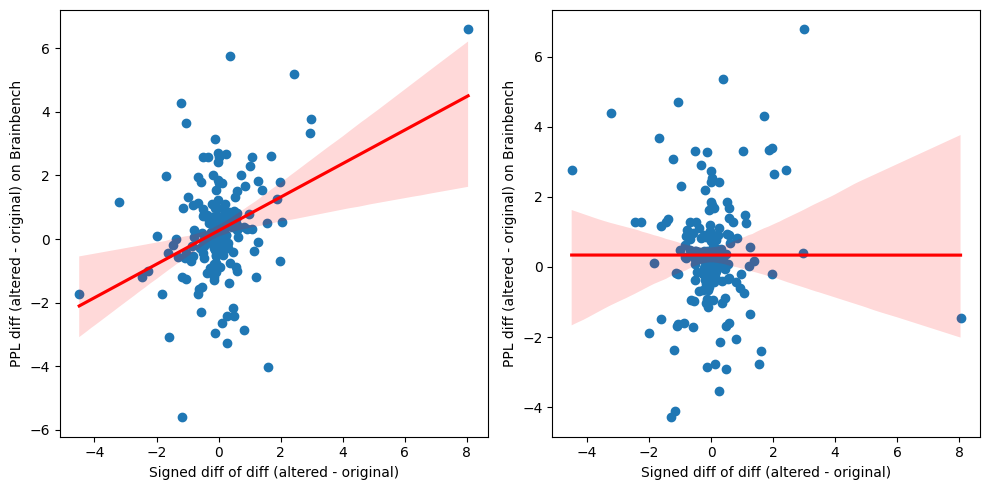

In [105]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(
    signed_diff_of_diff, 
    fwd_bayes_brainbench_ppls_diff_norm,
)

# Fit line
sns.regplot(
    x=signed_diff_of_diff,
    y=fwd_bayes_brainbench_ppls_diff_norm,
    ax=axes[0],
    scatter=False,
    color="red",
)

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    signed_diff_of_diff, fwd_bayes_brainbench_ppls_diff_norm
)
print("\nBayes Fwd model")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

axes[0].set_xlabel("Signed diff of diff (altered - original)")
axes[0].set_ylabel("PPL diff (altered - original) on Brainbench")

axes[1].scatter(
    signed_diff_of_diff, 
    rev_bayes_brainbench_ppls_diff_norm
)

# Fit line
sns.regplot(
    x=signed_diff_of_diff,
    y=rev_bayes_brainbench_ppls_diff_norm,
    ax=axes[1],
    scatter=False,
    color="red",
)

axes[1].set_xlabel("Signed diff of diff (altered - original)")
axes[1].set_ylabel("PPL diff (altered - original) on Brainbench")

# Plot slope significance
slope, intercept, r_value, p_value, std_err = stats.linregress(
    signed_diff_of_diff, rev_bayes_brainbench_ppls_diff_norm
)

print("\nBayes Rev model")
print("-" * 20)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

plt.tight_layout()